In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# ==========================================================================================
#
#  NOTEBOOK FOR FINE-TUNING GEMMA 3 1B
#
# ------------------------------------------------------------------------------------------
#
#  **DISCLAIMER**
#
#  This notebook is intended for educational purposes only.
#
#  - Date: July 2025
#  - Not suitable for production environments.
#  - Use at your own risk.
#
# ==========================================================================================
#
#  Overview:
#
#  This notebook provides a step-by-step guide to fine-tuning the Gemma 3 1B model.
#  The process involves:
#
#      01. Serving the Gemma 3 1B base model.
#      02. Fine-tuning the model with a datacenter rules dataset.
#      03. Saving the fine-tuned model in a GCS Bucket.
#      04. Serving the fine-tuned model and comparing its answers with the base model.
#
# ------------------------------------------------------------------------------------------
#
#  Requirements:
#  - A Google Cloud Platform (GCP) project and its id.
#  - A GCS Bucket.
#  - A Colab Enterprise on a g2-standard-16 runtime with an NVIDIA L4 GPU (24 GB).
#  - A HuggingFace account that acknowledge Gemma 3 1b Terms and its read permission API token.
#
# ==========================================================================================

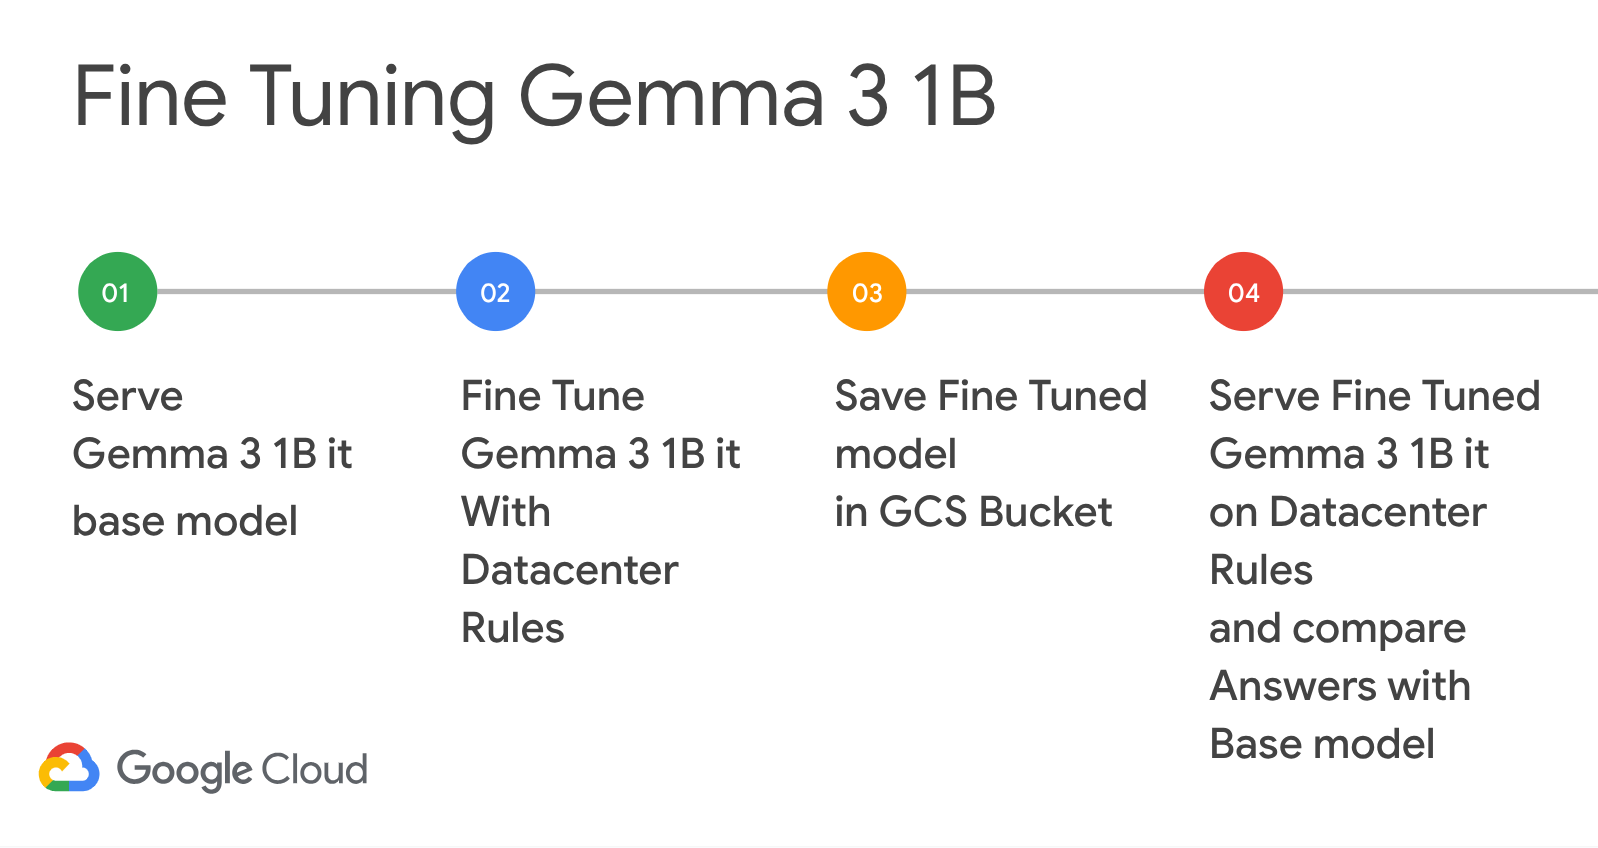

In [ ]:
!pip install -q gcsfs

In [ ]:
!pip install -q -U transformers datasets accelerate peft trl bitsandbytes vllm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.2/376.2 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#  restart session to use the python package installed
import os
os.kill(os.getpid(), 9)

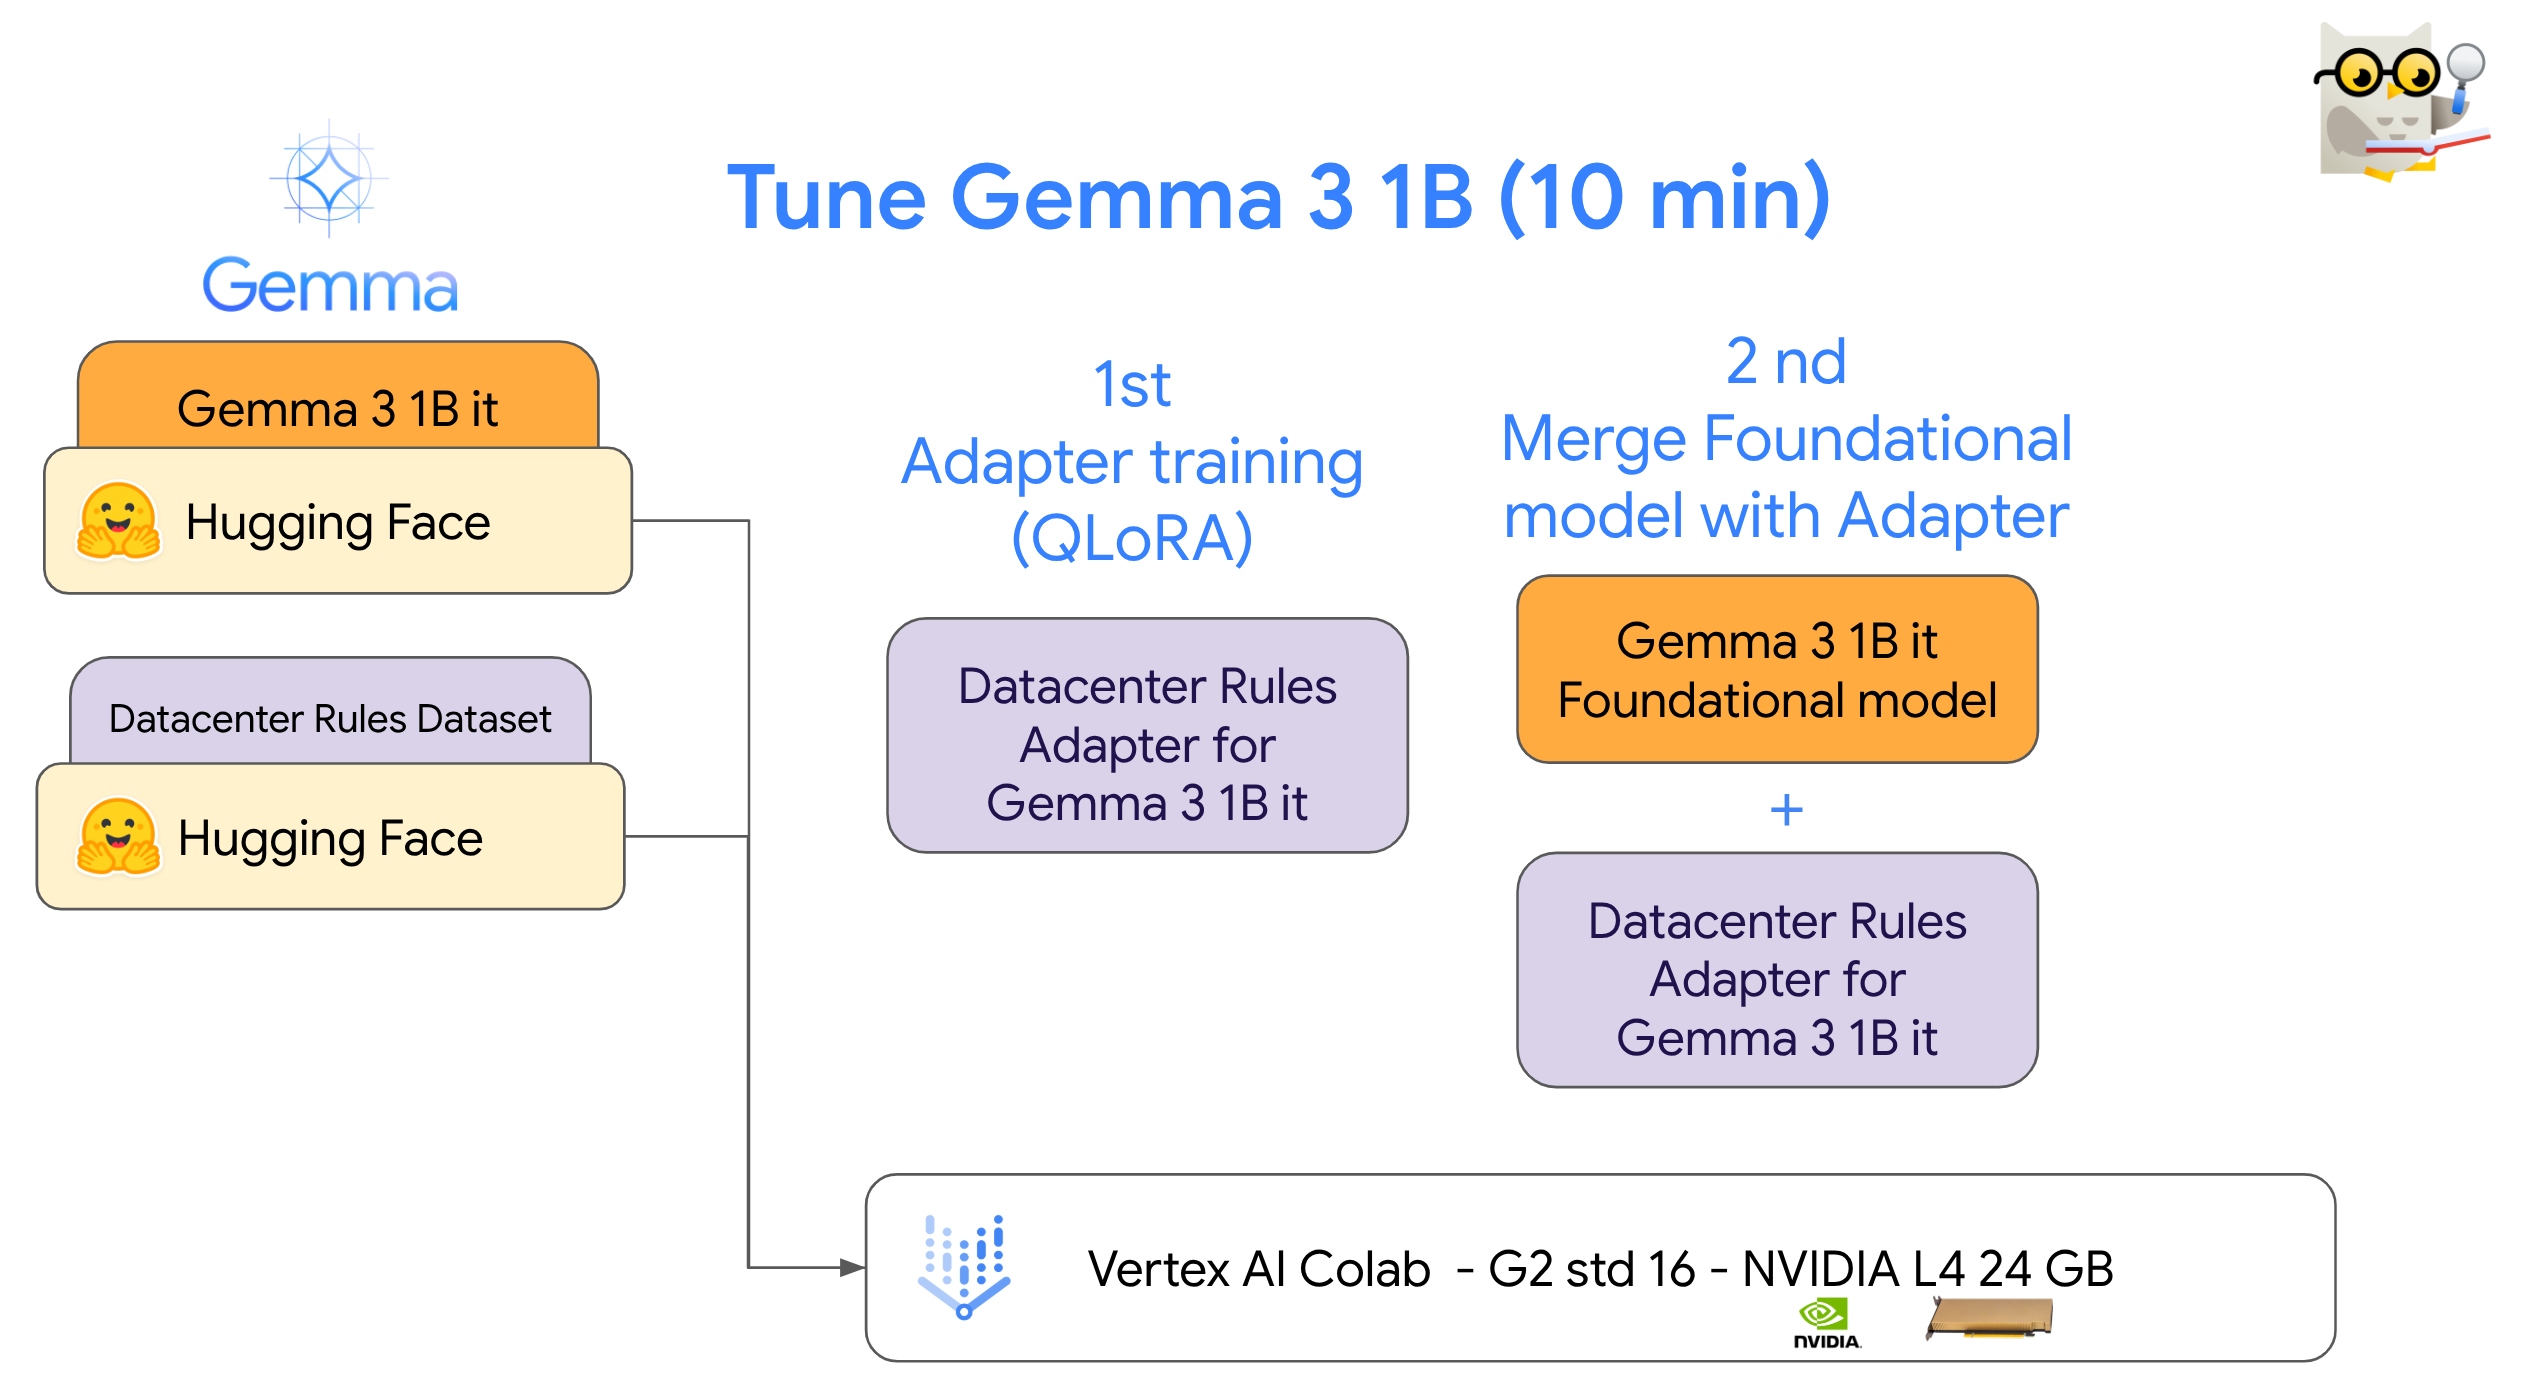

In [ ]:
# Login your HuggingFace Account
import notebook_login
notebook_login()
# Execute and paste your token

In [ ]:
#necessary imports
import torch
import gc
import os
import re
from datasets import load_dataset
from peft import LoraConfig, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from trl import SFTTrainer
from vllm import LLM, SamplingParams
from google.cloud import storage

# ==============================================================================
# === CONFIGURATION: SET THESE VALUES                                        ===
# ==============================================================================
GCP_PROJECT_ID = "cloud-llm-preview4"
GCS_BUCKET_NAME = "bkfft"
# ==============================================================================

# --- GCS Helper Functions ---
def create_gcs_bucket_if_not_exists(bucket_name, project_id):
    client = storage.Client(project=project_id)
    try:
        client.get_bucket(bucket_name)
    except Exception:
        client.create_bucket(bucket_name, project=project_id)
    print(f"Bucket {bucket_name} is ready.")

def upload_directory_to_gcs(local_path, bucket_name, gcs_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    for root, _, files in os.walk(local_path):
        for name in files:
            local_file = os.path.join(root, name)
            gcs_file = os.path.join(gcs_path, os.path.relpath(local_file, local_path))
            blob = bucket.blob(gcs_file)
            blob.upload_from_filename(local_file)
    print(f"Successfully uploaded {local_path} to gs://{bucket_name}/{gcs_path}")

def upload_file_to_gcs(local_path, bucket_name, gcs_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(gcs_path)
    blob.upload_from_filename(local_path)
    print(f"Successfully uploaded {local_path} to gs://{bucket_name}/{gcs_path}")

# --- Main Script Configuration ---
# Use the instruction-tuned model as the base, per the working example
BASE_MODEL_ID = "google/gemma-3-1b-it"
DATASET_ID = "fredmo/gemma_ft_dc_rules_dataset"
TRAINING_OUTPUT_DIR = "./results"
MERGED_MODEL_DIR = "./merged_fine_tuned_model"
BASE_ANSWER_FILE = "base_model_answer.txt"

os.makedirs(TRAINING_OUTPUT_DIR, exist_ok=True)
os.makedirs(MERGED_MODEL_DIR, exist_ok=True)

def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

print("--- Starting Script 1: Tune, Merge, and Upload ---")
create_gcs_bucket_if_not_exists(GCS_BUCKET_NAME, GCP_PROJECT_ID)

# --- Step 1: Base Inference ---
# Serve Gemma 3 1B it base model

print("\n--- Performing base inference ---")
llm_base = None
try:
    # Use settings from the working example
    llm_base = LLM(
        model=BASE_MODEL_ID,
        trust_remote_code=True,
        dtype=torch.float16,
        gpu_memory_utilization=0.5 # Use less memory to be safe
    )
    question = "What are Cloud Front Ends and how do they relate to customer VMs in Google Cloud?"
    sampling_params = SamplingParams(temperature=0.7, top_p=0.9, max_tokens=256)

    # The -it model uses a chat template, so we must use it
    tokenizer_base = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
    messages = [{"role": "user", "content": question}]
    prompt = tokenizer_base.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    outputs = llm_base.generate([prompt], sampling_params)
    base_model_answer = outputs[0].outputs[0].text.strip()
    with open(BASE_ANSWER_FILE, "w") as f: f.write(base_model_answer)
    print(f"\nBase model answer saved to {BASE_ANSWER_FILE}")
finally:
    if llm_base: del llm_base
    clear_gpu_memory()
    print("Base inference complete and resources cleared.")

# --- Step 2: Fine-tuning ---
# Fine Tune Gemma 3 1B it With Datacenter Rules #
print("\n--- Performing fine-tuning ---")
trainer = None
model = None
try:
    dataset = load_dataset(DATASET_ID, split="train").shuffle(seed=42)
    compute_dtype = torch.float16
    bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype)
    model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_ID, quantization_config=bnb_config, device_map="auto", trust_remote_code=True)
    model.config.use_cache = False
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
    tokenizer.pad_token = tokenizer.eos_token
    peft_config = LoraConfig(lora_alpha=16, lora_dropout=0.1, r=64, bias="none", task_type="CAUSAL_LM")
    training_args = TrainingArguments(output_dir=TRAINING_OUTPUT_DIR, num_train_epochs=2, per_device_train_batch_size=2, gradient_accumulation_steps=2, optim="adamw_torch", save_strategy="epoch", logging_steps=25, learning_rate=2e-4, fp16=True, max_grad_norm=0.3, warmup_ratio=0.03, group_by_length=True, lr_scheduler_type="constant", report_to="none")
    formatted_dataset = dataset.map(lambda ex: {"text": tokenizer.apply_chat_template(ex["messages"], tokenize=False)})
    trainer = SFTTrainer(model=model, train_dataset=formatted_dataset, peft_config=peft_config,args=training_args)
    trainer.train()
    print("\nFine-tuning complete.")
finally:
    if 'model' in locals(): del model
    if 'trainer' in locals(): del trainer
    clear_gpu_memory()
    print("Fine-tuning resources cleared.")

# Find the path to the trained adapter
checkpoint_dirs = [d for d in os.listdir(TRAINING_OUTPUT_DIR) if d.startswith("checkpoint-")]
latest_checkpoint_name = max(checkpoint_dirs, key=lambda d: int(re.search(r"(\d+)", d).group(1)))
ADAPTER_PATH = os.path.join(TRAINING_OUTPUT_DIR, latest_checkpoint_name)
print(f"Using adapter from: {ADAPTER_PATH}")

# --- Merge Adapter into a Full Model ---
print("\n--- Merging adapter to create a full model for vLLM ---")
try:
    base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_ID, torch_dtype=torch.float16, trust_remote_code=True)
    merged_model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
    merged_model = merged_model.merge_and_unload()
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
    merged_model.save_pretrained(MERGED_MODEL_DIR)
    tokenizer.save_pretrained(MERGED_MODEL_DIR)
    print(f"Full fine-tuned model for vLLM saved to {MERGED_MODEL_DIR}")
finally:
    if 'base_model' in locals(): del base_model
    if 'merged_model' in locals(): del merged_model
    clear_gpu_memory()
    print("Merging resources cleared.")

# --- Step 3: Upload All Artifacts to GCS ---
# Save Fine Tuned model in GCS Bucket #
print("\n--- Uploading all artifacts to GCS ---")
# Upload the full merged model (for the primary vLLM path)
upload_directory_to_gcs(MERGED_MODEL_DIR, GCS_BUCKET_NAME, "full_merged_model")
# Upload the raw adapter (for the PEFT fallback path)
upload_directory_to_gcs(ADAPTER_PATH, GCS_BUCKET_NAME, "lora_adapter")
# Upload the base model's answer
upload_file_to_gcs(BASE_ANSWER_FILE, GCS_BUCKET_NAME, "base_model_answer.txt")
print("\n--- Script 1 Finished Successfully. ---")

--- Starting Script 1: Tune, Merge, and Upload ---
Bucket bkfft is ready.

--- Performing base inference ---
INFO 07-20 20:40:17 [config.py:841] This model supports multiple tasks: {'reward', 'generate', 'classify', 'embed'}. Defaulting to 'generate'.
WARNING 07-20 20:40:17 [config.py:3371] Casting torch.bfloat16 to torch.float16.
INFO 07-20 20:40:17 [config.py:1472] Using max model len 32768
INFO 07-20 20:40:17 [config.py:2285] Chunked prefill is enabled with max_num_batched_tokens=8192.


/usr/local/lib/python3.11/dist-packages/transformers/models/gemma3/configuration_gemma3.py:242: FutureWarning: The `sliding_window_pattern` attribute is deprecated and will be removed in v4.55.0.
  warnings.warn(


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Base model answer saved to base_model_answer.txt
Base inference complete and resources cleared.

--- Performing fine-tuning ---


Tokenizing train dataset:   0%|          | 0/199 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/199 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
It is strongly recommended to train Gemma3 models with the `eager` attention implementation instead of `sdpa`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


Step,Training Loss
25,5.279700
50,2.665200
75,1.861900
100,1.646500



Fine-tuning complete.
Fine-tuning resources cleared.
Using adapter from: ./results/checkpoint-100

--- Merging adapter to create a full model for vLLM ---
Full fine-tuned model for vLLM saved to ./merged_fine_tuned_model
Merging resources cleared.

--- Uploading all artifacts to GCS ---
Successfully uploaded ./merged_fine_tuned_model to gs://bkfft/full_merged_model
Successfully uploaded ./results/checkpoint-100 to gs://bkfft/lora_adapter
Successfully uploaded base_model_answer.txt to gs://bkfft/base_model_answer.txt

--- Script 1 Finished Successfully. ---


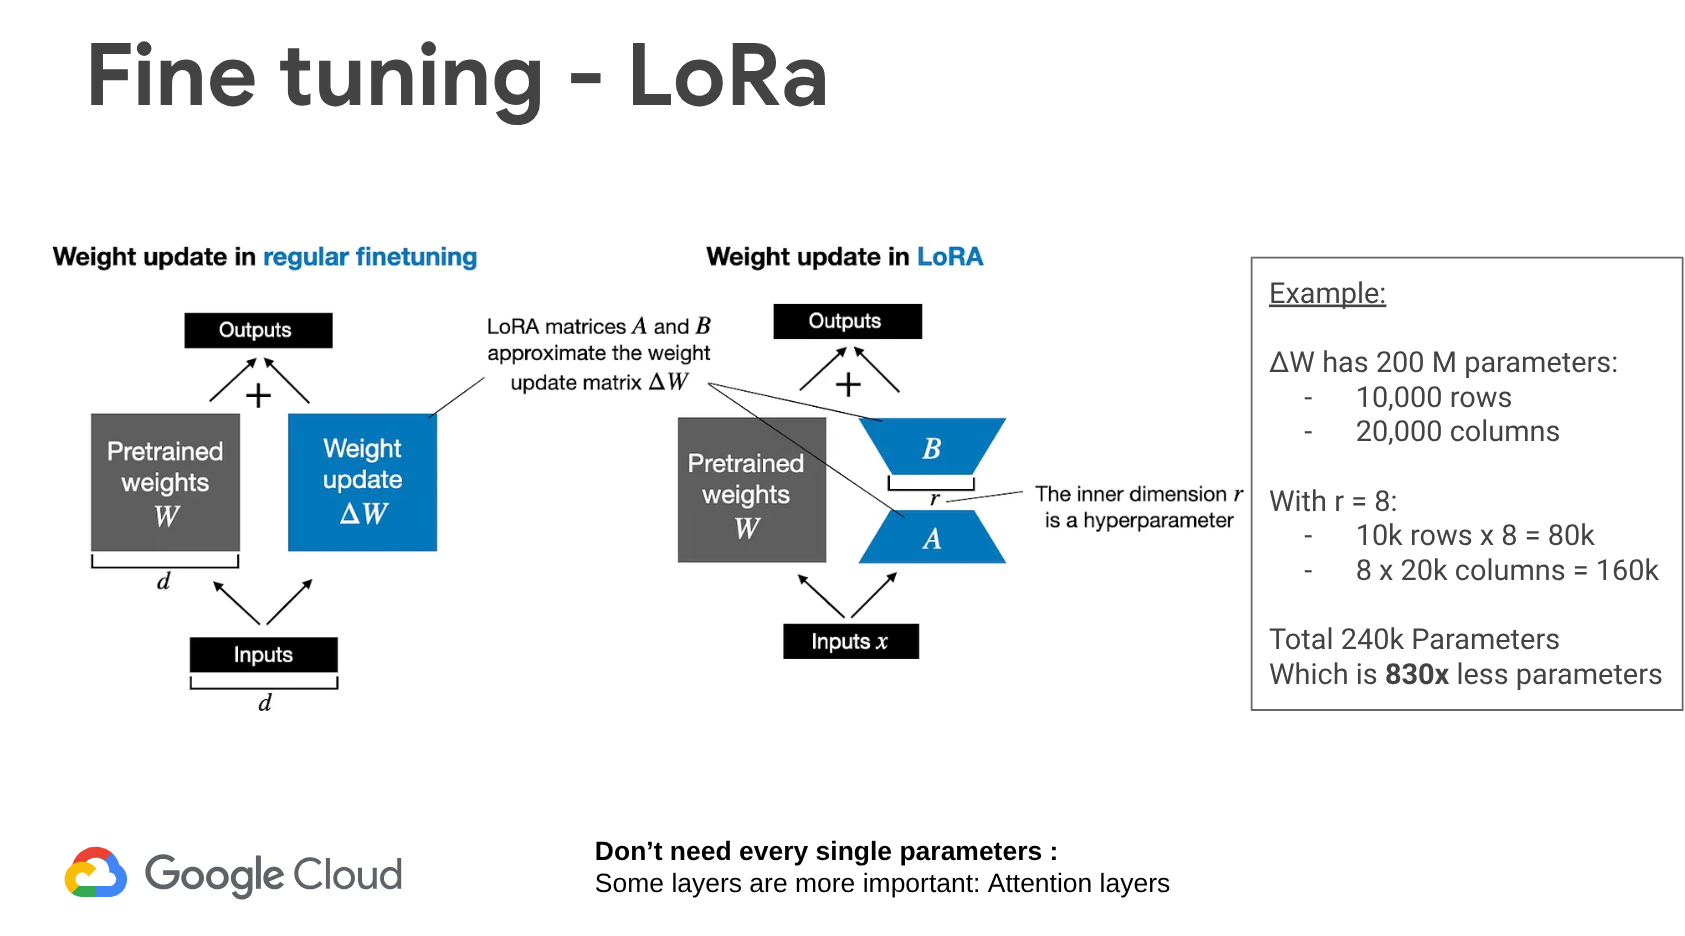

In [ ]:
# necessary imports
import torch
import gc
import os
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from google.cloud import storage

# ==============================================================================
# === CONFIGURATION: SET THESE VALUES                                        ===
# ==============================================================================
GCP_PROJECT_ID = "cloud-llm-preview4"
GCS_BUCKET_NAME = "bkfft"
# ==============================================================================

# --- GCS Helper Functions ---
def download_gcs_directory(bucket_name, gcs_path, local_path):
    os.makedirs(local_path, exist_ok=True)
    client = storage.Client(project=GCP_PROJECT_ID)
    bucket = client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=gcs_path)
    for blob in blobs:
        if blob.name.endswith("/"): continue
        destination_uri = os.path.join(local_path, os.path.relpath(blob.name, gcs_path))
        os.makedirs(os.path.dirname(destination_uri), exist_ok=True)
        blob.download_to_filename(destination_uri)
    print(f"Successfully downloaded gs://{bucket_name}/{gcs_path} to {local_path}")

def download_gcs_file(bucket_name, gcs_path, local_path):
    client = storage.Client(project=GCP_PROJECT_ID)
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(gcs_path)
    blob.download_to_filename(local_path)
    print(f"Successfully downloaded gs://{bucket_name}/{gcs_path} to {local_path}")

# --- Local Configuration ---
BASE_MODEL_ID = "google/gemma-3-1b-it" # Use the -it version
LOCAL_MERGED_MODEL_PATH = "./downloaded_merged_model"
LOCAL_ADAPTER_PATH = "./downloaded_adapter"
BASE_ANSWER_FILE_LOCAL = "./base_model_answer_downloaded.txt"

def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

def generate_with_vllm(llm, prompt):
    """Generates text using an initialized vLLM engine."""
    sampling_params = SamplingParams(temperature=0.7, top_p=0.9, max_tokens=256)
    outputs = llm.generate([prompt], sampling_params)
    return outputs[0].outputs[0].text.strip()

def generate_with_peft(model, tokenizer, prompt):
    """Generates text using a transformers/PEFT model."""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=256, pad_token_id=tokenizer.eos_token_id)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # The response from generate includes the prompt, so we remove it.
    return response[len(prompt):]


print("--- Starting Script 2: Download and Infer with Fallback ---")

# ---  Download all artifacts from GCS ---
print("\n--- Downloading all artifacts from GCS ---")
download_gcs_directory(GCS_BUCKET_NAME, "full_merged_model", LOCAL_MERGED_MODEL_PATH)
download_gcs_directory(GCS_BUCKET_NAME, "lora_adapter", LOCAL_ADAPTER_PATH)
download_gcs_file(GCS_BUCKET_NAME, "base_model_answer.txt", BASE_ANSWER_FILE_LOCAL)

# --- Try to initialize and use vLLM for Serving Fine Tuned Model (Primary Method) ---
finetuned_model_answer = None
try:
    print("\n Attempting to use primary method: vLLM with full merged model")
    llm = LLM(
        model=LOCAL_MERGED_MODEL_PATH,
        trust_remote_code=True,
        max_model_len=2048,
        gpu_memory_utilization=0.8,
        dtype=torch.float16,
    )
    tokenizer = AutoTokenizer.from_pretrained(LOCAL_MERGED_MODEL_PATH)

    question = "What are Cloud Front Ends and how do they relate to customer VMs in Google Cloud?"
    messages = [{"role": "user", "content": question}]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    finetuned_model_answer = generate_with_vllm(llm, prompt)
    print("vLLM method succeed")
    del llm # Release GPU's VRAM
    clear_gpu_memory()

except Exception as e:
    print(f"vLLM failed: {e}")
    finetuned_model_answer = None # Ensure it's None so the fallback runs

# --- Fallback to Transformers + PEFT if vLLM failed for serving the Fine Tuned Model ---
if finetuned_model_answer is None:
    try:
        print("\n Fall back, secondary method: Transformers + PEFT")
        # Load base model
        base_model = AutoModelForCausalLM.from_pretrained(
            BASE_MODEL_ID,
            torch_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True
        )
        # Apply adapter
        peft_model = PeftModel.from_pretrained(base_model, LOCAL_ADAPTER_PATH)
        tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)

        question = "What are Cloud Front Ends and how do they relate to customer VMs in Google Cloud?"
        messages = [{"role": "user", "content": question}]
        prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

        finetuned_model_answer = generate_with_peft(peft_model, tokenizer, prompt)
        print("PEFT fallback method succeed")
        del base_model, peft_model # Release GPU's VRAM
        clear_gpu_memory()

    except Exception as e2:
        print(f"PEFT fallback also failed: {e2}")
        finetuned_model_answer = "Error: Both vLLM and PEFT methods failed to generate a response. Check back your Fine Tuned Model, adapter, config files or folder location."

# --- Step 4: Read Base Answer and Display Final Results ---
print("\n--- Reading base model answer from file ---")
with open(BASE_ANSWER_FILE_LOCAL, "r") as f:
    base_model_answer = f.read()

print("\n\n" + "==========" + " FINAL RESULTS " + "==========")
print("\n## Desired Answer: ##")
print("Cloud Front Ends are specific GFEs located in the same cloud region as customer VMs for minimizing latency. They allow customer VMs to communicate with Google APIs and services without needing external IP addresses.")
print("\n ## Base Model Answer: ## ")
print(base_model_answer)
print("\n ## Fine-tuned Model Answer:  ##")
print(finetuned_model_answer)
print("\n" + "==========")

print("\n--- Script 2 Finished. ---")

--- Starting Script 2: Download and Infer with Fallback ---

--- Downloading all artifacts from GCS ---
Successfully downloaded gs://bkfft/full_merged_model to ./downloaded_merged_model
Successfully downloaded gs://bkfft/lora_adapter to ./downloaded_adapter
Successfully downloaded gs://bkfft/base_model_answer.txt to ./base_model_answer_downloaded.txt

🚀 Attempting to use primary method: vLLM with full merged model...
INFO 07-20 20:44:39 [config.py:841] This model supports multiple tasks: {'reward', 'generate', 'classify', 'embed'}. Defaulting to 'generate'.
INFO 07-20 20:44:39 [config.py:1472] Using max model len 2048
INFO 07-20 20:44:39 [config.py:2285] Chunked prefill is enabled with max_num_batched_tokens=8192.


/usr/local/lib/python3.11/dist-packages/transformers/models/gemma3/configuration_gemma3.py:242: FutureWarning: The `sliding_window_pattern` attribute is deprecated and will be removed in v4.55.0.
  warnings.warn(


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

✅ vLLM method successful!

--- Reading base model answer from file ---


========================= FINAL RESULTS =========================

**Desired Answer:**
Cloud Front Ends are specific GFEs located in the same cloud region as customer VMs for minimizing latency. They allow customer VMs to communicate with Google APIs and services without needing external IP addresses.

**Base Model Answer (from GCS):**
Okay, let's break down Cloud Front End and its relationship to Google Cloud Customer VMs. It's a relatively new and increasingly important concept, so let's go through it step-by-step.

**1. What is Cloud Front?**

Cloud Front is Google Cloud’s new content delivery network (CDN) service. Think of it as a globally distributed, intelligent content delivery system. It’s designed to significantly improve the performance and efficiency of your website and applications by caching and delivering content closer to users.

**Key Features & How it Works:**

* **Caching:** Cloud Front caches s

In [ ]:
## We can see that the base model is providing a wrong answer stating wrongly that Cloud Front is a Google Cloud CDN.
## The fine tuned Model learnt from the dataset and provides the correct answer about Cloud Front Ends
## dataset source, see page 12: https://cloud.google.com/docs/security/infrastructure/design/resources/google_infrastructure_whitepaper_fa.pdf
## Online version : https://cloud.google.com/docs/security/infrastructure/design
## dataset : https://huggingface.co/datasets/fredmo/gemma_ft_dc_rules_dataset

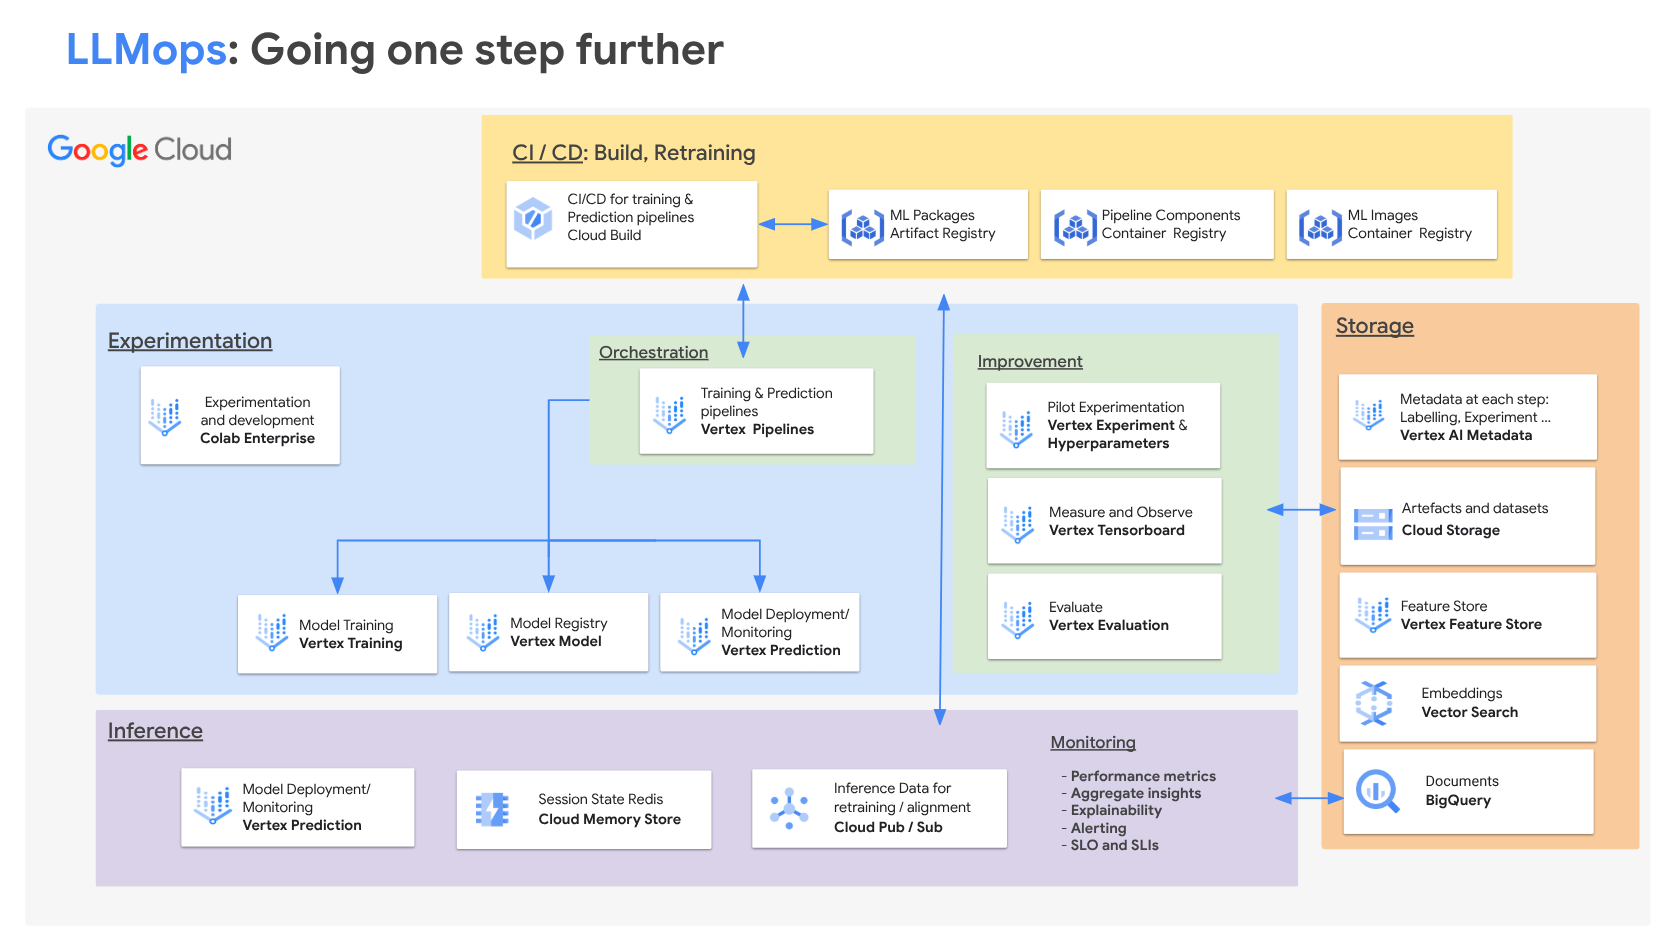
